In [1]:
import os
import sys
from pathlib import Path
from functools import partial
import logging
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.linalg import eigh, eigvalsh
import h5py
import jax
import jax.numpy as jnp
from jax.sharding import PartitionSpec, NamedSharding
from jax.experimental.ode import odeint
from qiskit.quantum_info import SparsePauliOp
from heavyhex_qft.triangular_z2 import TriangularZ2Lattice
from skqd_z2lgt.parameters import Parameters
from skqd_z2lgt.extensions import denoising, perturbation_2q
from skqd_z2lgt.circuits import make_plaquette_circuits
from skqd_z2lgt.sqd import sqd
from skqd_z2lgt.utils import read_bits
from skqd_z2lgt.tasks.common import make_dual_lattice
from skqd_z2lgt.jax_experimental_sparse_linalg import lobpcg_standard
sys.path.append('/home/iiyama/src/skqd_z2lgt/lib')
from unitary_krylov import make_hvec, make_trotter_uvec, integrate, simulate, sample, exact_diag, compute_gen_eigvals

logging.basicConfig(level=logging.INFO)
os.environ['CUDA_VISIBLE_DEVICES'] = '1,2,3,6'
jax.config.update('jax_enable_x64', True)

data_dir = Path('/data/iiyama/2dz2/unitary_krylov')

In [3]:
configs = [
   '''
 * *
* * *
 * *
   ''',
   '''
 * * *
* * * *
 * * *
   ''',
   '''
 * * * *
* * * * *
 * * * *
   ''',
   '''
 * * *
* * * *
 * * *
* * * *
   ''',
   '''
  * * *
 * * * *
* * * * *
 * * * *
   ''',
   '''
 * * *
* * * *
 * * *
* * * *
 * * *
   ''',
   '''
 * * * *
* * * * *
 * * * *
* * * * *
   '''
]

configs_large = [
   '''
  * * *
 * * * *
* * * * *
 * * * *
  * * *
   ''',
   '''
   * *
  * * *
 * * * *
* * * * *
 * * * *
  * * *
   ''',
]

config_30 = '''
   * *
  * * *
 * * * *
* * * * *
 * * * *
  * * *
   * *
'''

configs_all = configs + configs_large

In [4]:
nplaqs = []
for config in configs:
    nplaq = TriangularZ2Lattice(config).num_plaquettes
    print(nplaq)
    nplaqs.append(nplaq)
nplaqs = np.array(nplaqs)

nplaqs_large = []
for config in configs_large:
    nplaq = TriangularZ2Lattice(config).num_plaquettes
    print(nplaq)
    nplaqs_large.append(nplaq)
nplaqs_large = np.array(nplaqs_large)
nplaqs_all = np.concatenate([nplaqs, nplaqs_large])

6
10
14
15
19
20
21
24
27


## Exact eigenvalues and eigenvectors (ground and first excited)

In [5]:
plaquette_energy = 1.
exact_eigvals = {}
# exact_eigvecs = {}
filename = data_dir / 'exact_diag.h5'
if os.path.exists(filename):
    with h5py.File(filename, libver='latest') as source:
        for nplaq in nplaqs_all:
            exact_eigvals[nplaq] = source[f'eigvals_n{nplaq}'][()]
            # exact_eigvecs[nplaq] = source[f'eigvecs_n{nplaq}'][()]
else:
    with h5py.File(filename, 'w', libver='latest') as out:
        for nplaq, config in zip(nplaqs_all, configs_all):
            print(nplaq)
            vals, vecs = exact_diag(config, plaquette_energy)
            exact_eigvals[nplaq] = vals
            # exact_eigvecs[nplaq] = vecs
            out.create_dataset(f'eigvals_n{nplaq}', data=vals)
            out.create_dataset(f'eigvecs_n{nplaq}', data=vecs)

## Heat maps of dt versus D for different system sizes

In [6]:
def compute_ediffs(config, plaquette_energy=None, krylov_dim=None, delta_ts=None, num_substeps=2):
    dual_lattice = TriangularZ2Lattice(config).plaquette_dual()
    nplaq = dual_lattice.num_plaquettes

    filename = data_dir / f'psi_sim_n{nplaq}.h5'
    if os.path.exists(filename):
        with h5py.File(filename, libver='latest') as source:
            delta_ts = source['delta_ts'][()]
            # psi_sims = source['psi_sims'][()]
            ediffs = source['ediffs'][()]
    else:
        gen_eigvals = compute_gen_eigvals(config, plaquette_energy, krylov_dim, delta_ts, num_substeps)
        ediffs = gen_eigvals - exact_eigvals[nplaq][0]

        with h5py.File(filename, 'w', libver='latest') as out:
            out.create_dataset('plaquette_energy', data=plaquette_energy)
            out.create_dataset('delta_ts', data=delta_ts)
            out.create_dataset('num_substeps', data=num_substeps)
            out.create_dataset('ediffs', data=ediffs)

    return ediffs, delta_ts

### 6 plaquettes

In [7]:
krylov_dim = 8
ediffs_6, delta_ts_6 = compute_ediffs(configs[0], 1., krylov_dim, np.linspace(0.002, 0.502, 201))

Text(0, 0.5, '${\\Delta}t$')

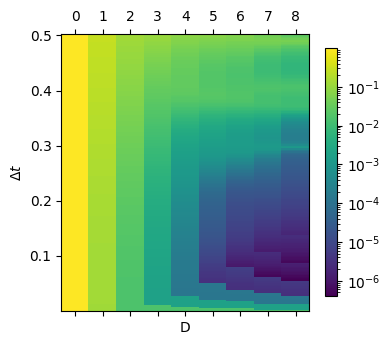

In [8]:
dd = delta_ts_6[1] - delta_ts_6[0]
plt.matshow(ediffs_6, origin='lower', norm=LogNorm(vmin=ediffs_6.min(), vmax=ediffs_6.max()),
            extent=[-0.5, krylov_dim + 0.5, delta_ts_6[0] - 0.5 * dd, delta_ts_6[-1] + 0.5 * dd],
            aspect=20.)
plt.colorbar(shrink=0.2)
#plt.xticks(np.arange(num_steps + 1), labels=[f'{i}' for i in range(num_steps + 1)])
plt.xlabel('D')
plt.ylabel(r'${\Delta}t$')

### 14 plaquettes

In [9]:
krylov_dim = 8
ediffs_14, delta_ts_14 = compute_ediffs(configs[2], 1., krylov_dim, np.linspace(0.002, 0.502, 201))

Text(0, 0.5, '${\\Delta}t$')

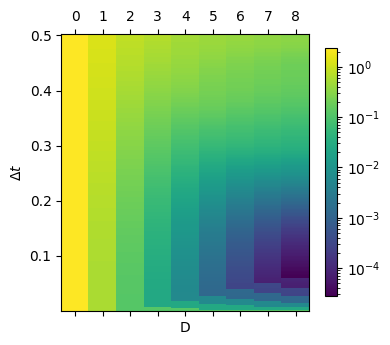

In [10]:
dd = delta_ts_14[1] - delta_ts_14[0]
plt.matshow(ediffs_14, origin='lower', norm=LogNorm(vmin=ediffs_14.min(), vmax=ediffs_14.max()),
            extent=[-0.5, krylov_dim + 0.5, delta_ts_14[0] - 0.5 * dd, delta_ts_14[-1] + 0.5 * dd],
            aspect=20.)
plt.colorbar(shrink=0.2)
#plt.xticks(np.arange(num_steps + 1), labels=[f'{i}' for i in range(num_steps + 1)])
plt.xlabel('D')
plt.ylabel(r'${\Delta}t$')

### 21 plaquettes

In [11]:
krylov_dim = 8
ediffs_21, delta_ts_21 = compute_ediffs(configs[6], 1., krylov_dim, np.linspace(0.002, 0.252, 51))

Text(0, 0.5, '${\\Delta}t$')

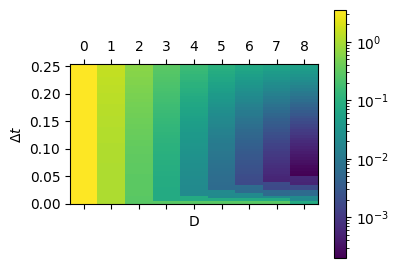

In [12]:
dd = delta_ts_21[1] - delta_ts_21[0]
plt.matshow(ediffs_21, origin='lower', norm=LogNorm(vmin=ediffs_21.min(), vmax=ediffs_21.max()),
            extent=[-0.5, krylov_dim + 0.5, delta_ts_21[0] - 0.5 * dd, delta_ts_21[-1] + 0.5 * dd],
            aspect=20.)
plt.colorbar(shrink=0.2)
#plt.xticks(np.arange(num_steps + 1), labels=[f'{i}' for i in range(num_steps + 1)])
plt.xlabel('D')
plt.ylabel(r'${\Delta}t$')

### 27 plaquettes

In [13]:
with h5py.File(data_dir / 'gen_eigvals_n27.h5', libver='latest') as source:
    gen_eigvals = source['gen_eigvals'][()]
    delta_ts_27 = source['delta_ts'][()]
ediffs_27 = gen_eigvals - exact_eigvals[27][0]

Text(0, 0.5, '${\\Delta}t$')

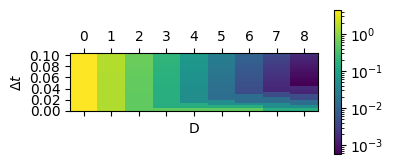

In [14]:
dd = delta_ts_27[1] - delta_ts_27[0]
plt.matshow(ediffs_27, origin='lower', norm=LogNorm(vmin=ediffs_27.min(), vmax=ediffs_27.max()),
            extent=[-0.5, krylov_dim + 0.5, delta_ts_27[0] - 0.5 * dd, delta_ts_27[-1] + 0.5 * dd],
            aspect=20.)
plt.colorbar(shrink=0.2)
#plt.xticks(np.arange(num_steps + 1), labels=[f'{i}' for i in range(num_steps + 1)])
plt.xlabel('D')
plt.ylabel(r'${\Delta}t$')

In [16]:
idt, ns = np.unravel_index(np.argmin(ediffs_6), ediffs_6.shape)
best_6 = delta_ts_6[idt]
print('Best 6:', delta_ts_6[idt], ns)
idt, ns = np.unravel_index(np.argmin(ediffs_14), ediffs_14.shape)
best_14 = delta_ts_14[idt]
print('Best 14:', delta_ts_14[idt], ns)
idt, ns = np.unravel_index(np.argmin(ediffs_21), ediffs_21.shape)
best_21 = delta_ts_21[idt]
print('Best 21:', delta_ts_21[idt], ns)
idt, ns = np.unravel_index(np.argmin(ediffs_27), ediffs_27.shape)
best_27 = delta_ts_27[idt]
print('Best 27:', delta_ts_27[idt], ns)

Best 6: 0.057 8
Best 14: 0.062 8
Best 21: 0.052000000000000005 8
Best 27: 0.04699999999999999 8


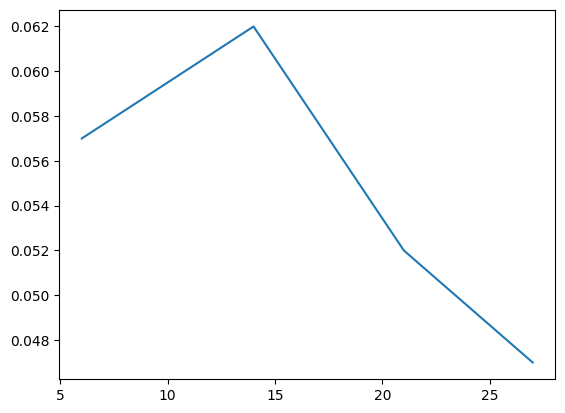

In [17]:
plt.plot([6, 14, 21, 27], [best_6, best_14, best_21, best_27])

In [21]:
print(np.pi / exact_eigvals[27][0])
print(np.pi / 117 * 0.8)

-0.06096471058297805
0.021480975409160982


## Exact versus Trotter evolution

In [ ]:
filename = data_dir / 'evolution.h5'

plaquette_energy = 1.
t_total = 1.6
num_steps = 8
delta_t = t_total / num_steps

if os.path.exists(filename):
    with h5py.File(filename, libver='latest') as source:
        t_full = source['t_full'][()]
        t_sim = source['t_sim'][()]
        psi_fulls = [source[f'psi_full_n{nplaq}'][()] for nplaq in nplaqs]
        psi_sims = [source[f'psi_sim_n{nplaq}'][()] for nplaq in nplaqs]

else:
    t_full = np.linspace(0., t_total, 321)
    t_sim = np.linspace(0., t_total, num_steps + 1)
    psi_fulls = []
    psi_sims = []

    for config in configs:
        dual_lattice = TriangularZ2Lattice(config).plaquette_dual()
        nplaq = dual_lattice.num_plaquettes
        hamiltonian = dual_lattice.make_hamiltonian(plaquette_energy)
        hvec = make_hvec(hamiltonian)
        psi_full = integrate(hvec, nplaq, t_full)
        psi_fulls.append(np.array(psi_full))

        trotter_uvec = make_trotter_uvec(hamiltonian, delta_t * 0.5)
        psi_sims.append(simulate(trotter_uvec, nplaq, num_steps))

6


INFO:2025-12-02 16:29:23,429:jax._src.xla_bridge:822: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


10
14
15
19
20
21


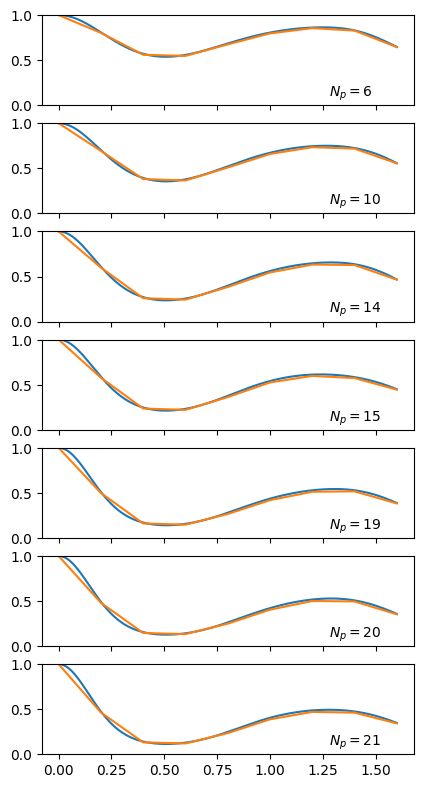

In [14]:
fig, axs = plt.subplots(len(psi_sims), 1, sharex=True, squeeze=True, figsize=(4.8, 9.6))
for ax, nplaq, psi_full, psi_sim in zip(axs, nplaqs, psi_fulls, psi_sims):
    ax.plot(t_full, np.square(np.abs(psi_full[:, 0])))
    ax.plot(t_sim, np.square(np.abs(psi_sim[:, 0])))
    ax.set_ylim(0., 1.)
    ax.text(t_full[-1] * 0.8, 0.1, f'$N_p={nplaq}$')

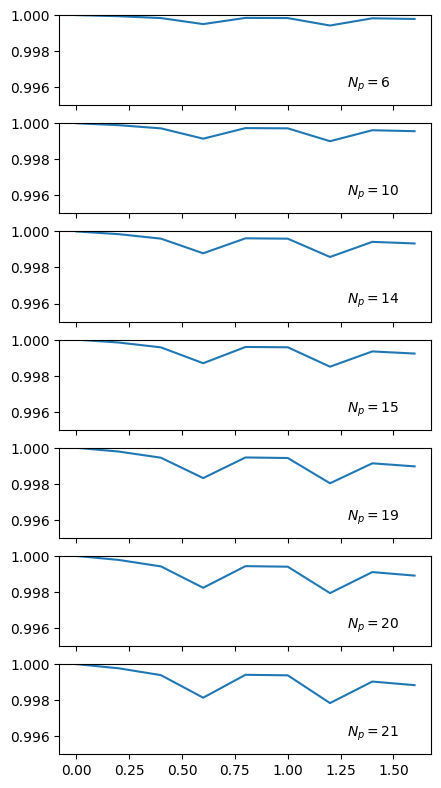

In [15]:
tidx = np.searchsorted(t_full, t_sim)
fidelities_tend = []

fig, axs = plt.subplots(len(psi_sims), 1, sharex=True, squeeze=True, figsize=(4.8, 9.6))
for ax, nplaq, psi_full, psi_sim in zip(axs, nplaqs, psi_fulls, psi_sims):
    fidelities = np.square(np.abs(np.einsum('ti,ti->t', psi_full[tidx].conjugate(), psi_sim)))
    ax.plot(t_sim, fidelities)
    ax.set_ylim(0.995, 1.)
    ax.text(t_sim[-1] * 0.8, 0.996, f'$N_p={nplaq}$')
    fidelities_tend.append(fidelities[-1])

In [ ]:
t_ends = np.linspace(0., t_total, 2)

for config in configs_large:
    dual_lattice = TriangularZ2Lattice(config).plaquette_dual()
    nplaq = dual_lattice.num_plaquettes
    print(nplaq)
    hamiltonian = dual_lattice.make_hamiltonian(plaquette_energy)
    with jax.default_device(jax.devices()[1]):
        hvec = make_hvec(hamiltonian)
        psi_full = integrate(hvec, nplaq, t_ends)

        trotter_uvec = make_trotter_uvec(hamiltonian, delta_t * 0.5)
        psi_sim = simulate(trotter_uvec, nplaq, num_steps)

        fidelities_tend.append(np.square(np.abs(psi_full[1].conjugate() @ psi_sim[-1])))


24
27


In [17]:
for psi_full in psi_fulls:
    print(np.sum(np.square(np.abs(psi_full[-1]))))

0.9999999841950421
0.9999999059938498
0.9999994970322914
0.9999992344173574
0.9999963750516527
0.9999945793223294
0.9999918959026612


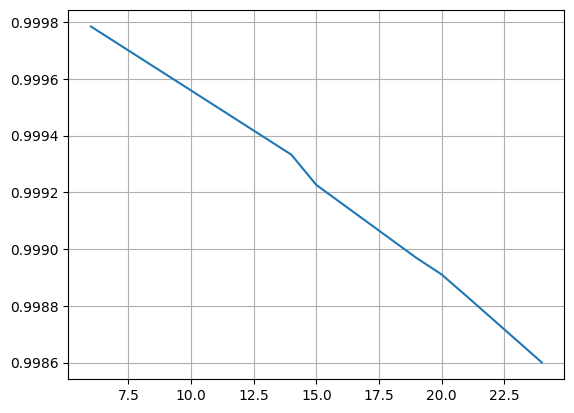

In [20]:
plt.plot(nplaqs_all[:-1], fidelities_tend[:-1])
plt.grid()

In [32]:
np.linalg.eigh(hamiltonian.to_matrix())[0][0]

np.float64(-12.998896080525332)

In [ ]:
plaquette_energy = 0.
delta_t = 0.1
num_steps = 8
config = configs[0]

lambdas = np.linspace(0., 4., 40)
gaps = np.empty_like(lambdas)
for ie, plaquette_energy in enumerate(lambdas):
    dual_lattice = TriangularZ2Lattice(config).plaquette_dual()
    nplaq = dual_lattice.num_plaquettes
    hamiltonian = dual_lattice.make_hamiltonian(plaquette_energy)
    hmat = hamiltonian.to_matrix()
    eigvals, eigvecs = np.linalg.eigh(hmat)
    gaps[ie] = eigvals[1] - eigvals[0]

plt.plot(lambdas, gaps)

In [ ]:
sortidx = np.argsort(probs[:, 0])[::-1]
for idx in sortidx:
    print((idx >> np.arange(6)[::-1]) % 2, eigvecs[idx, 0])

In [ ]:
def excited_links(plaq_state, dual_lattice):
    rev_link_state = np.array(dual_lattice.base_link_state[::-1])
    for ip in np.nonzero(plaq_state[::-1])[0]:
        rev_link_state[dual_lattice.primal.plaquette_links(ip)] ^= 1
    return np.nonzero(rev_link_state)[0]

In [ ]:
pkgpath = Path('/mnt/miyabi_p14000/data/full156_q_20_23_K_1_dt_01')
with open(pkgpath / 'parameters.json', 'r', encoding='utf-8') as source:
    params = Parameters.model_validate_json(source.read())

In [ ]:
lattice = TriangularZ2Lattice(params.lgt.lattice)
dual_lattice = make_dual_lattice(params)
hamiltonian = dual_lattice.make_hamiltonian(params.lgt.plaquette_energy)
lattice.draw_graph();

In [ ]:
with h5py.File(pkgpath / 'data/reco/exp_step0.h5') as source:
    plaq_data = read_bits(source['plaq'])

In [ ]:
states_1 = perturbation_2q(np.zeros((0, 64), dtype=np.uint8), dual_lattice, 3)
pert_energy, pert_eigvec, _, pert_hproj = sqd(hamiltonian, states_1)

In [ ]:
pert_energy

In [ ]:
with h5py.File(pkgpath / 'dmrg.h5') as source:
    print(source['energy'][()])

In [ ]:
exp_data = []
for istep in range(params.skqd.n_trotter_steps):
    with h5py.File(pkgpath / f'data/reco/ref_step{istep}.h5') as source:
        exp_data.append(read_bits(source['plaq']))
# exp_data = np.unique(np.concatenate(exp_data, axis=0), axis=0)
exp_data = np.concatenate(exp_data)

In [ ]:
np.count_nonzero(np.sum(exp_data, axis=1) == 0)

In [ ]:
exp_energy, exp_eigvec, _, exp_hproj = sqd(hamiltonian, exp_data)

In [ ]:
np.count_nonzero(np.sum(exp_data, axis=1) == 1)

In [ ]:
with h5py.File(pkgpath / 'skqd_rcv.h5') as source:
    print(source['energy'][()])
    sqd_states = read_bits(source['sqd_states'])
    sqd_eigvec = source['eigvec'][()]

In [ ]:
sqd_probs = np.square(np.abs(sqd_eigvec))
selection = sqd_probs > 1.e-20
relevant_states = sqd_states[selection]
relevant_probs = sqd_probs[selection]

In [ ]:
sortidx = np.argsort(relevant_probs)[::-1]
relevant_states_sorted = relevant_states[sortidx]
relevant_probs_sorted = relevant_probs[sortidx]

In [ ]:
num_exc = np.sum(relevant_states_sorted, axis=1)

In [ ]:
np.nonzero(num_exc == 2)[0]

In [ ]:
num_exc[:65]

In [ ]:
relevant_probs_sorted[:65]

In [ ]:
relevant_states.shape

In [ ]:
states = np.unique(states, axis=0)

In [ ]:
np.all(states[:100] == relevant_states[:100])

In [ ]:
np.sum(relevant_states, axis=1)

In [ ]:
denoised = denoising(plaq_data[:2], dual_lattice)[2:]

In [ ]:
ishot = 1
rev_link_state = np.array(dual_lattice.base_link_state[::-1])
for ip in np.nonzero(plaq_data[ishot][::-1])[0]:
    rev_link_state[lattice.plaquette_links(ip)] ^= 1
excited_links = np.nonzero(rev_link_state)[0]
lattice.draw_graph(vertices=[20, 23], links=excited_links);

In [ ]:
rev_link_state = np.array(dual_lattice.base_link_state[::-1])
for ip in np.nonzero(denoised[ishot][::-1])[0]:
    rev_link_state[lattice.plaquette_links(ip)] ^= 1
excited_links = np.nonzero(rev_link_state)[0]
lattice.draw_graph(vertices=[20, 23], links=excited_links);

In [ ]:
subgraph = lattice.graph.edge_subgraph([(0, 1), (2, 3)])

In [ ]:
import rustworkx as rx
rx.connected_components(subgraph)

In [ ]:
plaq_link_matrix = np.zeros((lattice.num_plaquettes, lattice.num_links), dtype=np.uint8)
for ip in range(lattice.num_plaquettes):
    plaq_link_matrix[::-1, ::-1][ip, lattice.plaquette_links(ip)] = 1

In [ ]:
link_states = np.bitwise_xor.reduce(plaq_data[..., None] * plaq_link_matrix[None, ...], axis=1)

In [ ]:
lattice.draw_graph(links=np.nonzero((dual_lattice.base_link_state ^ link_states[2])[::-1])[0]);

In [ ]:
ishot = 2
rev_link_state = np.array(dual_lattice.base_link_state[::-1])
for ip in np.nonzero(plaq_data[ishot][::-1])[0]:
    rev_link_state[lattice.plaquette_links(ip)] ^= 1
excited_links = np.nonzero(rev_link_state)[0]
lattice.draw_graph(vertices=[20, 23], links=excited_links);

In [ ]:
set(np.nonzero([0, 1])[0].tolist())

In [ ]:
lattice.graph.subgraph([43, 44]).edges()

In [ ]:
pkgpath

In [ ]:
with h5py.File(pkgpath / 'skqd_rcv.h5') as source:
    eigvec = source['eigvec'][()]
    states = read_bits(source['sqd_states'])

In [ ]:
probs = np.square(np.abs(eigvec))
sort_idx = np.argsort(probs)[::-1]

istate = 0
plaq_state = states[sort_idx[istate]]

In [ ]:
states[sort_idx[0]]

In [ ]:
states[sort_idx[1]]

In [ ]:
lattice.draw_graph(vertices=[20, 23], links=excited_links(states[sort_idx[9]], dual_lattice));

In [ ]:
probs[sort_idx[:10]]